In [430]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 300)
import re
import string
from time import time
from functools import partial
from collections import Counter
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torchmetrics import F1Score

# импортируем трансформеры
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#### DATASET

In [4]:
df = pd.read_csv('../datasets/dataset_task2.csv')
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)\n",1.0


In [483]:
df.shape

(14412, 3)

In [97]:
df.groupby(by=df['toxic']).count()

,comment,cleaned_content
toxic,,
0.0,9586,9586
1.0,4826,4826


In [74]:
def data_preprocessing(text: str) -> str:
    text = text.lower()
    text = re.sub(r'(https://\w.*).*|(http://\w.*).*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation
    # text = ''.join(text)
    return text

df['cleaned_content'] = df['comment'].apply(data_preprocessing)

In [76]:
df['cleaned_content'][6]

'в шапке были ссылки на инфу по текущему фильму марвел эти ссылки были заменены на фразу репортим брипидора игнорируем его посты если этого недостаточно чтобы понять что модератор абсолютный неадекват и его нужно лишить полномочий тогда эта борда пробивает абсолютное дно по неадекватности\n'

#### LOAD MODEL

In [263]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [463]:
model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer_rtt = AutoTokenizer.from_pretrained(model_checkpoint)
model_rtt = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

In [464]:
# fine tunuing with freeze last classifier layer 
for name, param in model_rtt.named_parameters():
    if 'encoder.layer.2' in name or 'pooler' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Создаем новую "голову" с несколькими слоями
num_features = model_rtt.classifier.in_features # # Количество входов от базовой модели
num_classes = 1 # Количество ваших классов
model_rtt.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes)
)
model_rtt.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [465]:
num_features

312

In [466]:
model_rtt.classifier

Sequential(
  (0): Linear(in_features=312, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=1, bias=True)
)

In [467]:
# Разделяем данные на обучающую и валидационную выборки
train_text, valid_text, train_label, valid_label = train_test_split(df['cleaned_content'].to_list(),
                                                                    df['toxic'].to_list(),
                                                                    test_size=0.3,
                                                                    shuffle=True,
                                                                    random_state=42)

# Токенизируем тексты
# padding='max_length' - дополняет все последовательности до максимальной длины
# truncation=True - обрезает слишком длинные последовательности
MAX_LEN = 128
train_encod = tokenizer_rtt(train_text, truncation=True, padding='max_length',
                            max_length=MAX_LEN, return_tensors='pt')

valid_encod = tokenizer_rtt(valid_text, truncation=True, padding='max_length',
                            max_length=MAX_LEN, return_tensors='pt')

In [468]:
# Создаем сэмплер, для уравнивания дисбаланса классов
# replacement=True позволяет выбирать один и тот же элемент несколько раз
class_counts = Counter(train_label)
class_weights = {label: 1.0 / count for label, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_label]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [469]:
# Создание кастомного Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encoding, labels):
        self.encoding = encoding
        self.labels = labels
    # Этот метод возвращает общее количество элементов в датасете
    def __len__(self):
        return len(self.labels)
    
    # Этот метод возвращает один элемент датасета по индексу idx
    # DataLoader многократно вызывает этот метод, чтобы набрать нужное количество образцов для одного батча
    def __getitem__(self, idx):
        # encodings - это словарь ('input_ids', 'attention_mask'), 
        # извлекаем тензоры для каждого ключа
        item = {key: val[idx] for key, val in self.encoding.items()}
        # Добавляем метку класса
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [470]:
# Создаем экземпляры нашего датасета для обучающей и валидационной выборок
train_dataset = TextDataset(train_encod, train_label)
valid_dataset = TextDataset(valid_encod, valid_label)

#  Создание DataLoaders
BATCH_SIZE = 64

# Создаем загрузчики данных
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    shuffle=False    # Перемешивать данные в каждой эпохе (важно для обучения)
                     # ВАЖНО: при использовании sampler, shuffle должен быть False!
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False    # На валидации перемешивать не нужно
)

In [471]:
# optimizer = torch.optim.Adam(model_rtt.classifier.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_rtt.parameters()), lr=1e-5)
f1 = F1Score(task="binary") 
# Модели Hugging Face сами возвращают loss, если переданы labels
# criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

In [472]:
def train(num_epochs=1, 
          model=model_rtt,
          optimizer=optimizer,
        #   criterion=criterion,
          train_loader=train_loader,
          valid_loader=valid_loader,
          f1_score = f1.to(device)
          ):
    model_rtt.to(device)
    history = {
        'epochs': [],
        'loss_train': [],
        'loss_valid': [],
        'accuracy_train': [],
        'accuracy_valid': [],
        'f1_score': [],
    }

    for epoch in range(num_epochs):
        # --- Фаза обучения ---
        model.train()  # Переводим модель в режим обучения
        running_loss = 0.0
        corrects = 0
        
        for batch in tqdm(train_loader):
            # Извлекаем данные из словаря по ключам
            # и перемещаем на нужное устройство
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            
            # 1. Обнуляем градиенты
            optimizer.zero_grad()
            
            # 2. Прямой проход (forward pass)
            # Используем распаковку словаря для удобной передачи в модель
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=label.unsqueeze(1))
            # loss = criterion(torch.sigmoid(outputs.logits), label.unsqueeze(1))
            # Модели Hugging Face сами возвращают loss, если переданы labels
            loss = outputs.loss
            
            # 3. Обратное распространение ошибки (backward pass)
            loss.backward()
            
            # 4. Обновление весов
            optimizer.step()
            
            running_loss += loss.item() * input_ids.size(0)
            # Получаем вероятности с помощью Sigmoid
            preds = torch.sigmoid(outputs.logits)
            # Превращаем вероятности в предсказанные классы (0 или 1) порогом 0.5
            preds = (preds > 0.5).long()
            corrects += torch.sum(preds == label.unsqueeze(1))

        epoch_loss = running_loss / len(train_loader.dataset)

        train_epoch_acc = corrects.double() / len(train_loader.dataset)

        # --- Фаза валидации ---
        model.eval()  # Переводим модель в режим оценки
        val_loss = 0.0
        corrects = 0
        
        with torch.no_grad(): # Отключаем вычисление градиентов
            for batch in tqdm(valid_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                label = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=label.unsqueeze(1))
                
                # loss = criterion(torch.sigmoid(outputs.logits), label.unsqueeze(1))
                loss = outputs.loss
                
                # Получаем вероятности с помощью Sigmoid
                preds = torch.sigmoid(outputs.logits)
                # Превращаем вероятности в предсказанные классы (0 или 1) порогом 0.5
                preds = (preds > 0.5).long()
                # print(torch.max(preds))
                val_loss += loss.item() * input_ids.size(0)
                # print(preds, label)
                corrects += torch.sum(preds == label.unsqueeze(1))
                # Обновляем метрику на каждом батче
                f1_score.update(preds, label.unsqueeze(1))

        val_epoch_loss = val_loss / len(valid_loader.dataset)
        val_epoch_acc = corrects.double() / len(valid_loader.dataset)
        # После окончания цикла по всем батчам вычисляем итоговый F1-score
        final_f1_score = f1_score.compute()

        print(f"Эпоха {epoch+1}/{num_epochs}\n"
            f"Потери на обучении: {epoch_loss:.3f} | "
            f"Потери на валидации: {val_epoch_loss:.3f}\n"
            f"Точность на обучении: {train_epoch_acc:.3f} | "
            f"Точность на валидации: {val_epoch_acc:.3f}\n",
            f"F1-Score на валидации: {final_f1_score:.3f}")
        
        history['epochs'].append(epoch+1)
        history['loss_train'].append(epoch_loss)
        history['loss_valid'].append(val_epoch_loss)
        history['accuracy_train'].append(train_epoch_acc.item())
        history['accuracy_valid'].append(val_epoch_acc.item())
        history['f1_score'].append(final_f1_score.item())

        # Важно! Сбрасываем состояние метрики для следующей эпохи
        f1_score.reset()
    print("Обучение завершено.")
    
    return history

In [473]:
history = train(num_epochs=20)

100%|██████████| 68/68 [00:46<00:00,  1.46it/s]


Эпоха 1/20
Потери на обучении: 0.656 | Потери на валидации: 0.575
Точность на обучении: 0.685 | Точность на валидации: 0.849
 F1-Score на валидации: 0.783


100%|██████████| 68/68 [00:43<00:00,  1.57it/s]


Эпоха 2/20
Потери на обучении: 0.544 | Потери на валидации: 0.453
Точность на обучении: 0.830 | Точность на валидации: 0.857
 F1-Score на валидации: 0.799


100%|██████████| 68/68 [00:44<00:00,  1.51it/s]


Эпоха 3/20
Потери на обучении: 0.440 | Потери на валидации: 0.372
Точность на обучении: 0.852 | Точность на валидации: 0.866
 F1-Score на валидации: 0.813


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


Эпоха 4/20
Потери на обучении: 0.386 | Потери на валидации: 0.351
Точность на обучении: 0.858 | Точность на валидации: 0.863
 F1-Score на валидации: 0.815


100%|██████████| 68/68 [00:42<00:00,  1.59it/s]


Эпоха 5/20
Потери на обучении: 0.351 | Потери на валидации: 0.317
Точность на обучении: 0.867 | Точность на валидации: 0.876
 F1-Score на валидации: 0.827


100%|██████████| 68/68 [00:44<00:00,  1.52it/s]


Эпоха 6/20
Потери на обучении: 0.328 | Потери на валидации: 0.326
Точность на обучении: 0.872 | Точность на валидации: 0.869
 F1-Score на валидации: 0.822


100%|██████████| 68/68 [00:44<00:00,  1.52it/s]


Эпоха 7/20
Потери на обучении: 0.328 | Потери на валидации: 0.314
Точность на обучении: 0.874 | Точность на валидации: 0.875
 F1-Score на валидации: 0.828


100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


Эпоха 8/20
Потери на обучении: 0.310 | Потери на валидации: 0.307
Точность на обучении: 0.883 | Точность на валидации: 0.878
 F1-Score на валидации: 0.831


100%|██████████| 68/68 [00:44<00:00,  1.53it/s]


Эпоха 9/20
Потери на обучении: 0.303 | Потери на валидации: 0.290
Точность на обучении: 0.885 | Точность на валидации: 0.885
 F1-Score на валидации: 0.838


100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


Эпоха 10/20
Потери на обучении: 0.297 | Потери на валидации: 0.293
Точность на обучении: 0.886 | Точность на валидации: 0.884
 F1-Score на валидации: 0.837


100%|██████████| 68/68 [00:42<00:00,  1.60it/s]


Эпоха 11/20
Потери на обучении: 0.301 | Потери на валидации: 0.289
Точность на обучении: 0.884 | Точность на валидации: 0.885
 F1-Score на валидации: 0.838


100%|██████████| 68/68 [00:44<00:00,  1.53it/s]


Эпоха 12/20
Потери на обучении: 0.290 | Потери на валидации: 0.291
Точность на обучении: 0.890 | Точность на валидации: 0.883
 F1-Score на валидации: 0.836


100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


Эпоха 13/20
Потери на обучении: 0.294 | Потери на валидации: 0.294
Точность на обучении: 0.886 | Точность на валидации: 0.881
 F1-Score на валидации: 0.835


100%|██████████| 68/68 [05:58<00:00,  5.27s/it]


Эпоха 14/20
Потери на обучении: 0.291 | Потери на валидации: 0.288
Точность на обучении: 0.888 | Точность на валидации: 0.883
 F1-Score на валидации: 0.836


100%|██████████| 68/68 [00:46<00:00,  1.47it/s]


Эпоха 15/20
Потери на обучении: 0.296 | Потери на валидации: 0.283
Точность на обучении: 0.887 | Точность на валидации: 0.885
 F1-Score на валидации: 0.837


100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


Эпоха 16/20
Потери на обучении: 0.293 | Потери на валидации: 0.280
Точность на обучении: 0.888 | Точность на валидации: 0.888
 F1-Score на валидации: 0.841


100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


Эпоха 17/20
Потери на обучении: 0.292 | Потери на валидации: 0.280
Точность на обучении: 0.887 | Точность на валидации: 0.888
 F1-Score на валидации: 0.842


100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


Эпоха 18/20
Потери на обучении: 0.277 | Потери на валидации: 0.287
Точность на обучении: 0.894 | Точность на валидации: 0.886
 F1-Score на валидации: 0.840


100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


Эпоха 19/20
Потери на обучении: 0.274 | Потери на валидации: 0.280
Точность на обучении: 0.898 | Точность на валидации: 0.888
 F1-Score на валидации: 0.842


100%|██████████| 68/68 [00:45<00:00,  1.49it/s]

Эпоха 20/20
Потери на обучении: 0.271 | Потери на валидации: 0.290
Точность на обучении: 0.896 | Точность на валидации: 0.884
 F1-Score на валидации: 0.838
Обучение завершено.


In [486]:
history.keys()

dict_keys(['epochs', 'loss_train', 'loss_valid', 'accuracy_train', 'accuracy_valid', 'f1_score'])

In [491]:
min(history['loss_valid'])

0.2801996692256945

In [475]:
with open("../models/rtt_metrics.json", "w", encoding="utf-8") as file:
    json.dump(history, file, ensure_ascii=False, indent=4)

In [476]:
PATH = '../models/model_rtt.pth'

In [477]:
# сохранение модели
torch.save(model_rtt, PATH)

In [338]:
def text2toxicity(text):
    with torch.no_grad():
        # Токенизируем текст и перемещаем на нужное устройство
        inputs = tokenizer_rtt(text, return_tensors='pt', truncation=True, padding=True).to(device)
        # Токенизируем текст и перемещаем на нужное устройство
        proba = torch.sigmoid(model_rtt(**inputs).logits).squeeze(1).cpu().numpy()
    for p in proba:
        if p > 0.5:
            print(f'Оскорбительный текст, с вероятностью {p:.2f}')
        else:
            print(f'Не оскорбительный текст, с вероятностью {p:.2f}')
    return proba

In [350]:
t = valid_text[:10]
probability = text2toxicity(t)

Оскорбительный текст, с вероятностью 0.95
Не оскорбительный текст, с вероятностью 0.01
Не оскорбительный текст, с вероятностью 0.01
Оскорбительный текст, с вероятностью 0.80
Не оскорбительный текст, с вероятностью 0.02
Не оскорбительный текст, с вероятностью 0.02
Не оскорбительный текст, с вероятностью 0.02
Не оскорбительный текст, с вероятностью 0.01
Не оскорбительный текст, с вероятностью 0.09
Оскорбительный текст, с вероятностью 0.94


In [401]:
def get_predictions(model, data_loader, device):
    """
    Function to get a list of predictions for a given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            # Move data to the correct device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get model outputs (logits)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Convert logits to probabilities
            probs = torch.sigmoid(logits)

            # Convert probabilities to class predictions (0 or 1), для датафрема отключать эту строку
            preds = (probs > 0.5).long()

            # Add batch predictions to the list (move to CPU to save GPU memory)
            all_preds.extend(preds.cpu().numpy())
            # all_preds.extend(probs.cpu().numpy().flatten().tolist()) # для сравнение в датафрейме

    return all_preds

In [478]:
predicts = get_predictions(model_rtt, valid_loader, device)

In [403]:
predicts

[array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),

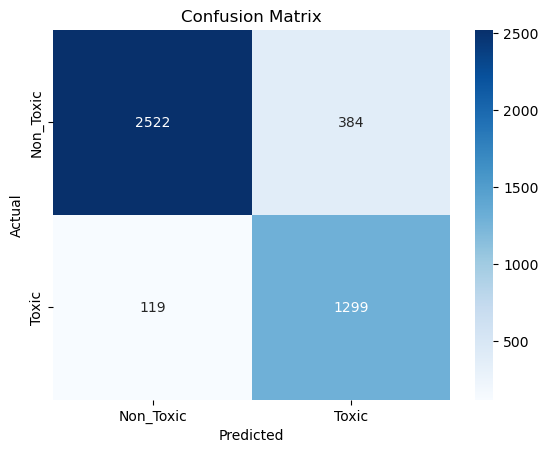

In [479]:
cm = confusion_matrix(valid_label, predicts)
df_cm = pd.DataFrame(cm, 
                     index=['Non_Toxic', 'Toxic'], 
                     columns=['Non_Toxic', 'Toxic'])
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

проверка неугаданных текстов

In [ ]:
check_df = pd.DataFrame({'text': valid_text,
            'predicts': predicts,
            'true_label': valid_label})

In [394]:
check_df['delta'] = check_df['predicts'] - check_df['true_label']
check_df['delta'] = check_df['delta'].abs()
check_df.sort_values(by='delta', ascending=False, inplace=True)

In [406]:
check_df

,text,predicts,true_label,delta
1600,на заводах работают смену 12 часов с 3 выходными вот в эти 3 выходных и начинается теневая экономика провинции 5к стоит поправить крыльцо со ступеньками заварить дырку в воротах 2к довести телевизор 500 рублей,0.009532,1.0,0.990468
1027,а зачем мне десяток одинаковых провайдеров с конскими ценами которые блокируют все сайты из списка ркн пусть будет государственный разницы никакой,0.010305,1.0,0.989695
4177,в том году делали проводку дома частично за деньги я была на 9 месяце электрик не жэковский сначала отправил меня сообщать всему подъезду что сейчас будет вырублен свет нет когда накануне всё обговаривали ни про какое объявление для соседей он не говорил хорошо середина буднего дня ну ок благо в...,0.010742,1.0,0.989258
346,не смешите меня даже на самой населенной трассе москвапетербург пассажирооборот 36 миллиона человек в год где вы найдете этих туристов вовторых эти поезда не будут останавливаться в этих городках это бессмыслица и это города ничего не получат от нее кроме перекрытых за полчаса дорог и забора вдо...,0.012968,1.0,0.987032
594,бывает меня вот бесит когда в предложении есть вставка поверь прям вот ухххбля сразу в голове всплывают воспоминания о разговорах за жизнь с бывалыми малолетками во времена школы института конечно и плюсом к этому частицы той невероятной дичи что они несли\n,0.013991,1.0,0.986009
...,...,...,...,...
1370,потому что индустрия игр не благотворительность нет они получили возможность заработать больше денег при том даже сделав части покупателей скидку почему не всем потому что заработать больше денег тоже важно мы же не задаемся вопросом почему эпики могут брать такую комиссию а стим дерет 30 по...,0.008857,0.0,0.008857
48,я стараюсь все равно тележки не бросать где попало но бывает другой возможности нет не могу представить ситуацию в которой нет возможности вернуть тележку а вообще способ интересный но имеет два серьёзных минуса стоимость размеры\n,0.008841,0.0,0.008841
2437,спасибо я знаю описано как будет строиться станция на 5 этапах материалы для ремонта можно трп пособирать я вчера еще сама могла долететь не очень то и далеко но сейчас посещаю туристические точки экспедиция будет там к пятнице\n,0.008831,0.0,0.008831
1835,трудно сказать что просядет а что нет евро до сих пор не подводил хотя есть мысль купить немного банковского золота немного мне предлагали такие маленькие слитки банки продают прикольная штука еще есть монеты банковские из золота я где то читал\n,0.008805,0.0,0.008805
